In [1]:
import glob
import os
import time

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID' 
os.environ['CUDA_VISIBLE_DEVICES']='3'

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision import datasets, transforms
# from torch.autograd import Variable
import torch.autograd as autograd
import torchvision.utils as vutils

from torch.utils.data import DataLoader, TensorDataset

In [2]:
def load_data():
    x_train = (h5py.File('camelyonpatch_level_2_split_train_x.h5', 'r')['x'][:, 16:80,16:80] - 127.5) / 127.5
    y_train = h5py.File('camelyonpatch_level_2_split_train_y.h5', 'r')['y'][:].reshape(-1,1)
    x_test = (h5py.File('camelyonpatch_level_2_split_test_x.h5', 'r')['x'][:, 16:80,16:80] - 127.5) / 127.5
    y_test = h5py.File('camelyonpatch_level_2_split_test_y.h5', 'r')['y'][:].reshape(-1,1)
    x_valid = (h5py.File('camelyonpatch_level_2_split_valid_x.h5', 'r')['x'][:, 16:80,16:80] - 127.5) / 127.5
    y_valid = h5py.File('camelyonpatch_level_2_split_valid_y.h5', 'r')['y'][:].reshape(-1,1)
              
    return x_train, y_train, x_test, y_test, x_valid, y_valid

def plot_samples(samples, folder=None, epoch=None, i=None):
    rt = int(np.sqrt(samples.shape[0]))
    r, c = rt, rt
    # r, c = 6, 12

    generatedImage = 0.5 * samples + 0.5

    fig = plt.figure(figsize=(10,10))

    axs = [fig.add_subplot(r,c,i+1) for i in range(r*c)]
    cnt = 0
    for ax in axs:
        ax.imshow(generatedImage[cnt],interpolation='nearest')
        ax.axis('off')
        ax.set_aspect('equal')
        cnt+=1
    fig.subplots_adjust(wspace=.004, hspace=.02)

    if folder:
        path = 'results/'+folder+'/samples'
        if not os.path.exists('results'):
            os.mkdir('results')
        if not os.path.exists('results/'+folder):
            os.mkdir('results/'+folder)
        if not os.path.exists(path):
            os.mkdir(path)
        step = ""
        if i:
            step = '_'+str(i)
        fig.savefig(path+'/epoch_%d%s.png' % (epoch, step))
        plt.close()


/home/aray/pathology_gan
26214


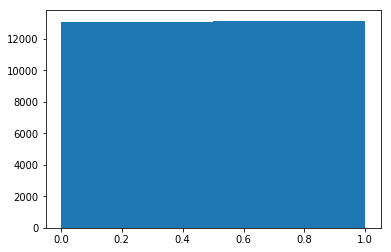

In [3]:
%cd "~/pathology_gan"

x_train, y_train, x_test, y_test, x_valid, y_valid = load_data()

x_train = torch.from_numpy(np.moveaxis(x_train.astype(np.float32), -1, 1))
x_test  = torch.from_numpy(np.moveaxis(x_test.astype(np.float32), -1, 1))
x_valid  = torch.from_numpy(np.moveaxis(x_valid.astype(np.float32), -1, 1))

y_train = torch.from_numpy(y_train).float() 
y_test = torch.from_numpy(y_test).float() 
y_valid = torch.from_numpy(y_valid).float() 

# X = torch.from_numpy(np.moveaxis(np.concatenate([x_train, x_test, x_valid]).astype(np.float32), -1, 1))
# y = torch.from_numpy(np.concatenate([y_train, y_test, y_valid]))

# trainloader = DataLoader(TensorDataset(x_train, y_train), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
validloader = DataLoader(TensorDataset(x_valid, y_valid), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)

percent = int(x_train.shape[0]*.1)
np.random.seed(17)
idx_small = np.random.choice(range(x_train.shape[0]), percent, replace=False)

x_train_small = x_train[idx_small]
y_train_small = y_train[idx_small]
trainloader = DataLoader(TensorDataset(x_train_small, y_train_small), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)

plt.hist(y_train_small.numpy(), bins=2)
print(percent)

In [4]:
y_train_small = y_train_small.type(torch.LongTensor)
y_valid=y_valid.type(torch.LongTensor)
trainloader = DataLoader(TensorDataset(x_train_small, y_train_small), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
validloader = DataLoader(TensorDataset(x_valid, y_valid), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)


In [5]:
# noise = np.random.normal(0,1,size=(16,100))
# imgs = saved_actor.predict(noise)
# plot_samples(imgs)

# imgs_real = .5+.5*np.moveaxis(x_train[np.random.choice(range(x_train.shape[0]), 12*6, replace=False)], -1, 1)
# plot_samples(x_train[np.random.choice(range(x_train.shape[0]), 12*6, replace=False)])
# print(imgs_real.shape)
# plt.figure(figsize=(24,12))
# plt.imshow(np.transpose(make_grid(torch.from_numpy(imgs_real), nrow=12, ).numpy(), (1, 2, 0)))

In [6]:
class Generator(nn.Module):
    def __init__(self, w, h, c, latent_dim):
        super(Generator, self).__init__()
        
        self.w = w
        self.h = h
        self.c = c
        self.latent_dim = latent_dim
        
        self.n_filters = 128
        
        self.input = nn.Sequential(
            nn.Linear(latent_dim, self.n_filters * w//4 * h//4),
            nn.ReLU()
        )
        
        self.deconv = nn.Sequential(
            nn.Upsample(size=[w//2, h//2], mode='nearest'),
            nn.Conv2d(self.n_filters, self.n_filters//2, 3, stride=1, padding=1),
            nn.ReLU(True),
            
            nn.Upsample(size=[w, h], mode='nearest'),
            nn.Conv2d(self.n_filters//2, self.n_filters//4, 4, stride=2, padding=1),
            nn.ReLU(True),
            
            nn.Upsample(size=[w, h], mode='nearest'),
            nn.Conv2d(self.n_filters//4, self.n_filters//8, 3, stride=1, padding=1),
            nn.ReLU(True),

            nn.Upsample(size=[w, h], mode='nearest'),
            nn.Conv2d(self.n_filters//8, self.n_filters//16, 4, stride=2, padding=1),
            nn.ReLU(True),

            nn.Upsample(size=[w, h], mode='nearest'),
            nn.Conv2d(self.n_filters//16, self.n_filters//32, 3, stride=1, padding=1),
            nn.ReLU(True),

            nn.Conv2d(self.n_filters//32, c, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        output = self.input(x)
        # print(output.shape)
        output = output.view(-1, self.n_filters, self.w//4, self.h//4)
        # print(output.shape)
        return self.deconv(output) #.view(-1, self.w, self.h, self.c)

class Discriminator(nn.Module):
    def __init__(self, h, w, c):
        super(Discriminator, self).__init__()
        
        self.w = w
        self.h = h
        self.c = c
        n_filters = 32

        self.conv = nn.Sequential(
            nn.Conv2d(c, n_filters, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(n_filters, 2*n_filters, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(2*n_filters, 4*n_filters, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten()
        )
        self.fc = nn.Linear(4*n_filters*int(w/2**3)*int(h/2**3), 2, bias=True)

    def forward(self, x, clf=True, dropout=True):
        flatten = self.conv(x)
        if dropout:
            flatten = F.dropout(flatten, p=0.5)
        
        out = self.fc(flatten)
        
        if clf:
            return F.softmax(out, dim=1)

#         expsum = torch.exp(out).sum(dim=1)
#         out = expsum/(expsum+1)
        return out, flatten



In [9]:
class SSL_WGAN:
    def __init__(self, w, h, c, model_name, latent_dim=100):
        self.model_name = model_name
        self.latent_dim = latent_dim 
        self.lambda_gp = 10
        self.lambda_ct = 2
        self.d_iterations = 5
        self.print_every = 10
        # CT multiplier
        self.M = .1
        self.use_cuda = True
        self.D = Discriminator(w, h, c)
        self.G = Generator(w, h, c, latent_dim)

        lr = 1e-4
        betas = (.9, .99)

        self.Clf_opt = optim.Adam(self.D.parameters(), lr=lr/2, betas=betas)
        self.Clf_criterion = torch.nn.CrossEntropyLoss()
        
        self.D_opt = optim.Adam(self.D.parameters(), lr=lr, betas=betas)
        self.G_opt = optim.Adam(self.G.parameters(), lr=lr, betas=betas)


        if self.use_cuda:
            self.D = self.D.cuda()
            self.G = self.G.cuda()

        if not os.path.exists('results/'+model_name):
            os.mkdir('results/'+model_name)

    def train(self, train_loader, validation_loader, X_unlabled, epochs, save_training_gif=True):
#         print(n_samples, n_samples//128)
        if save_training_gif:
            # Fix latents to see how image generation improves during training
            self.fixed_latents = torch.randn((12*6, self.latent_dim))
            if self.use_cuda:
                self.fixed_latents = self.fixed_latents.cuda()
            self.training_progress_images = []

        self.stats = {
            'clf_loss': [],
            'clf_acc': [],
            'clf_loss_val': [],
            'clf_acc_val': [],
            'g_loss': [],
            'd_loss': [],
            'd_loss_real': [],
            'd_loss_fake': [],
            'gp': [],
            'ct': [],
            
        }

        for epoch in range(epochs):
            clf_loss = []
            clf_acc = []
            g_loss = []
            d_loss = []
            d_loss_fake = []
            d_loss_real = []
            gradient_penalty = []
            consistency_term = []

#             for i, data in tqdm(enumerate(train_loader), desc="epoch "+str(epoch)):
            for i, data in enumerate(train_loader):
#                 if i%((n_samples//128)//100)==0:
#                     print(".", end="", flush=True)
                X = data[0]
                y = data[1].view(-1)
                batch_size = X.shape[0]
                idx_u = np.random.choice(X_unlabled.shape[0], batch_size, replace=False)
                X_u = X_unlabled[idx_u]
                if self.use_cuda:
                    X_u = X_u.cuda()
                    X = X.cuda()
                    y = y.cuda()
                    
                loss, acc = self._train_Clf(X, y)
                clf_loss.append(loss)
                clf_acc.append(acc)                                
                    
                ct, loss, gp = self._train_D(X_u)
#                 d_loss_real.append(r)
#                 d_loss_fake.append(g)
                gradient_penalty.append(gp)
                consistency_term.append(ct)
                d_loss.append(loss)
                
                # Only update generator every |d_iterations| iterations
#                 if i % self.d_iterations == 0:
                g_loss.append(self._train_G1(X_u))
            
            if epoch % 20 == 0:
                acc_val = self._eval_Clf(validation_loader)
                clf_loss_m = sum(clf_loss)/len(clf_loss)
                clf_acc_m = sum(clf_acc)/len(clf_acc)     
                g_loss_m = sum(g_loss)/len(g_loss)
                d_loss_m = sum(d_loss)/len(d_loss)
#                 real_m = sum(d_loss_real)/len(d_loss_real)
#                 fake_m = sum(d_loss_fake)/len(d_loss_fake)
                gp_m = sum(gradient_penalty)/len(gradient_penalty)
                ct_m = sum(consistency_term)/len(consistency_term)
                self.stats['clf_loss'].append(clf_loss_m)
                self.stats['clf_acc'].append(clf_acc_m)
    #             self.stats['clf_loss_val'].append(loss_val)
                self.stats['clf_acc_val'].append(acc_val)
                self.stats['g_loss'].append(g_loss_m)
                self.stats['d_loss'].append(d_loss_m)
#                 self.stats['d_loss_real'].append(real_m)
#                 self.stats['d_loss_fake'].append(fake_m)
                self.stats['gp'].append(gp_m)
                self.stats['ct'].append(ct_m)
                print("Epoch: %d, G loss: %f"%(epoch, g_loss_m))
                print("Clf loss: %f, acc: %.3f, acc_val: %.3f"%(clf_loss_m, clf_acc_m, acc_val))
                print("D loss: %f; ct: %f, gp: %f"%(d_loss_m, ct_m, gp_m))
            
            if epoch % 50 == 0:
                with torch.no_grad():
                    self.G.eval()
#                     self.D.eval()
#                     print(self.D(X_unlabled[:10].cuda()).view(-1))
#                     self.D.train()
                    imgs = self.G(torch.randn((16, self.latent_dim)).cuda()).cpu().numpy()
                    plot_samples(np.moveaxis(imgs, 1,-1), self.model_name, epoch)
                    self.G.train()

            if  epoch % 20 == 0 and save_training_gif:
                with torch.no_grad():
                    self.G.eval()
                    img_grid = vutils.make_grid(self.G(self.fixed_latents).cpu(), nrow=12).numpy()
                    # (width, height, channels)
                    img_grid = .5+.5*np.transpose(img_grid, (1, 2, 0))
                    self.training_progress_images.append(img_grid)
                    self.G.train()

            # if i % self.print_every == 0:
            #     print("Iteration {}".format(i + 1))
            #     print("D: {}".format(self.losses['D'][-1]))
            #     print("GP: {}".format(self.losses['GP'][-1]))
            #     print("Gradient norm: {}".format(self.losses['gradient_norm'][-1]))
            #     if self.num_steps > self.critic_iterations:
            #         print("G: {}".format(self.losses['G'][-1]))

        if save_training_gif:
            imageio.mimsave('results/'+self.model_name+'/training_{}_epochs.gif'.format(epochs), self.training_progress_images)

    def _eval_Clf(self, validation_loader):
        self.D.eval()        
        with torch.no_grad():
            acc = .0
            for i, data in enumerate(validation_loader):
                X = data[0]
                y = data[1].view(-1)
                if self.use_cuda:
                    X = X.cuda()
                    y = y.cuda()
                predicted = torch.argmax(self.D(X), dim=1)
                acc+=(predicted == y).sum()/float(predicted.shape[0])       
        self.D.train()
        return (acc/(i+1)).detach().item()

#     def _train_Clf(self, data, labels):
#         self.D_opt.zero_grad()
        
#         predicted = self.D(data, clf=True)
    
#         loss = self.Clf_criterion(predicted, labels)
        
#         loss.backward()
#         self.Clf_opt.step()    
      
#         acc = (predicted.detach().cpu() == labels.detach().cpu()).sum()/float(predicted.shape[0])

#         return loss.detach().item(), acc
    
    def _train_Clf(self, data, labels):
        self.D_opt.zero_grad()
        
        predicted = self.D(data, clf=True, dropout=True)
    
        loss = self.Clf_criterion(predicted, labels)
        
        loss.backward()
        self.Clf_opt.step()    
      
        acc = (torch.argmax(predicted.detach().cpu(), dim=1) == labels.detach().cpu()).sum()/float(predicted.shape[0])

        return loss.detach().item(), acc
        
#     def _D_loss(self, out):
#         expsum = torch.exp(out).sum(dim=1)
#         return expsum/(expsum+1)    
    
    def _train_D(self, data):
        self.D_opt.zero_grad()

        batch_size = data.shape[0]
        generated_data = self.sample_generator(batch_size)
        
        real_fc1, real_flatten1 = self.D(data, clf=False)
        real_fc2, real_flatten2 = self.D(data, clf=False)
        gen_fc, _ = self.D(generated_data, clf=False)
       
        ct = ((torch.softmax(real_fc1, dim=1) - torch.softmax(real_fc2, dim=1))**2).mean(dim=1) - self.M
        ct = torch.max(ct, torch.zeros_like(ct)).mean(dim=0)

        gen_mean = F.softplus(torch.logsumexp(gen_fc, dim=1)).mean()
        real_mean = F.softplus(torch.logsumexp(real_fc1, dim=1)).mean()
        
        gp = self._gradient_penalty(data, generated_data)

        d_loss =  0.5*(self.lambda_ct*ct - torch.logsumexp(real_fc1, dim=1).mean() + real_mean + gen_mean)+self.lambda_gp*gp
        
        d_loss.backward()
        self.D_opt.step()


        return ct.detach().item(), d_loss.detach().item(), gp.detach().item()

#     def _train_G(self, batch_size):
#         for p in self.D.parameters():
#             p.requires_grad = False
            
#         self.G_opt.zero_grad()

#         # Get generated data
#         generated_data = self.sample_generator(batch_size)

#         # Calculate loss and optimize
#         d_generated, _ = self.D(generated_data, clf=False)
#         g_loss = -d_generated.mean()
#         g_loss.backward()
#         self.G_opt.step()
        
#         for p in self.D.parameters():
#             p.requires_grad = True

        return g_loss.detach().item()
    
    def _train_G1(self, real_data):
        for p in self.D.parameters():
            p.requires_grad = False
            
        self.G_opt.zero_grad()

        batch_size = real_data.shape[0]
        generated_data = self.sample_generator(batch_size)

        _, d_real_output = self.D(real_data, clf=False, dropout=False)
        _, d_gen_output = self.D(generated_data, clf=False, dropout=False)

        g_loss = ((d_gen_output.mean(dim=0)-d_real_output.mean(dim=0))**2).mean()
        g_loss.backward()
        self.G_opt.step()
        
        for p in self.D.parameters():
            p.requires_grad = True

        return g_loss.detach().item()    

    def _gradient_penalty(self, real_data, generated_data):
        batch_size = real_data.shape[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data + (1 - alpha) * generated_data
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Calculate probability of interpolated examples
        dis_interpolated, _ = self.D(interpolated, clf=False)
        grad_outputs = torch.ones(dis_interpolated.shape)
        if self.use_cuda:
            grad_outputs=grad_outputs.cuda()

        # Calculate gradients of probabilities with respect to examples
        gradients = autograd.grad(outputs=dis_interpolated, inputs=interpolated,
                               grad_outputs=grad_outputs, create_graph=True, retain_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height),
        # so flatten to easily take norm per example in batch
        gradients = gradients.view(batch_size, -1)
#         self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data[0])

        # Derivatives of the gradient close to 0 can cause problems because of
        # the square root, so manually calculate norm and add epsilon
        gradients_norm = ((torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12) - 1) ** 2).mean()
        # Return gradient penalty
        return gradients_norm #((gradients.norm(2, dim=1) - 1) ** 2).mean()

#     def _consistency_term(self, real_data):
#         d1, d_1 = self.D(real_data, clf=False)
#         d2, d_2 = self.D(real_data, clf=False)

# #         ct = (d1 - d2).norm(2, dim=1) + 0.1 * (d_1 - d_2).norm(2, dim=1) - self.M
#         ct = self.lambda_ct*((d1.view(-1) - d2.view(-1))**2+0.1*((d_1.view(-1) - d_2.view(-1))**2).mean()) - self.M
#         return torch.max(ct, torch.zeros_like(ct)).mean()
        
    def sample_generator(self, num_samples):
        latent_samples = torch.randn((num_samples, self.latent_dim), requires_grad=True)
        if self.use_cuda:
            latent_samples = latent_samples.cuda()
        generated_data = self.G(latent_samples)
        return generated_data

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        # Remove color channel
        return generated_data.data.cpu().numpy()[:, 0, :, :]

In [ ]:
wgan_ct = SSL_WGAN(64, 64, 3, 'ssl_wgan2_gp_010')
wgan_ct.train(trainloader, validloader, x_train, 10000, x_train.shape[0])

Epoch: 0, G loss: 0.060940
Clf loss: 0.622590, acc: 0.664, acc_val: 0.737
D loss: 2.145309; ct: 0.006697, gp: 0.172351
Epoch: 20, G loss: 0.004431
Clf loss: 0.544860, acc: 0.755, acc_val: 0.751
D loss: 0.232932; ct: 0.007361, gp: 0.004593
Epoch: 40, G loss: 0.003657
Clf loss: 0.547228, acc: 0.755, acc_val: 0.754
D loss: 0.264242; ct: 0.012859, gp: 0.004205
Epoch: 60, G loss: 0.001968
Clf loss: 0.545721, acc: 0.755, acc_val: 0.741
D loss: 0.314338; ct: 0.011344, gp: 0.003220
Epoch: 80, G loss: 0.001885
Clf loss: 0.536275, acc: 0.766, acc_val: 0.759
D loss: 0.321649; ct: 0.013241, gp: 0.003207
Epoch: 100, G loss: 0.001757
Clf loss: 0.559450, acc: 0.746, acc_val: 0.731
D loss: 0.298760; ct: 0.012972, gp: 0.003094
Epoch: 120, G loss: 0.001654
Clf loss: 0.557326, acc: 0.749, acc_val: 0.739
D loss: 0.285970; ct: 0.014008, gp: 0.002868
Epoch: 140, G loss: 0.001402
Clf loss: 0.553794, acc: 0.753, acc_val: 0.746
D loss: 0.283715; ct: 0.014316, gp: 0.002705
Epoch: 160, G loss: 0.001344
Clf loss:

In [127]:
import csv
with open('results/ssl_wgan_010/ct.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(wgan_ct.stats['ct'])
print(np.argmax(wgan_ct.stats['clf_acc_val']))
wgan_ct.stats['clf_acc_val'][499]

491


0.79931640625

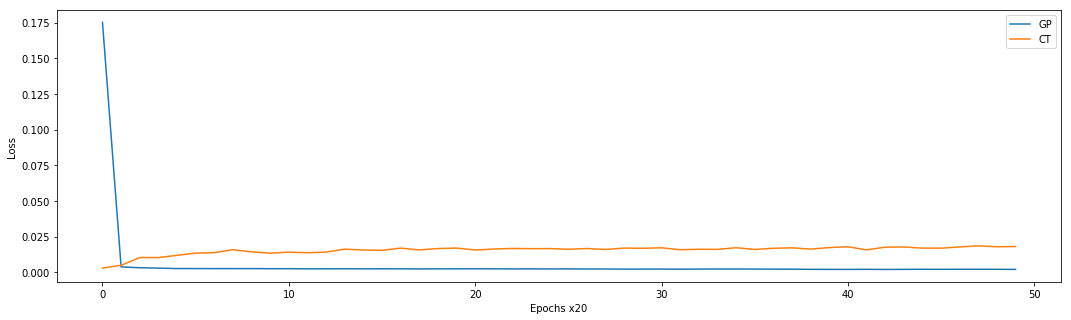

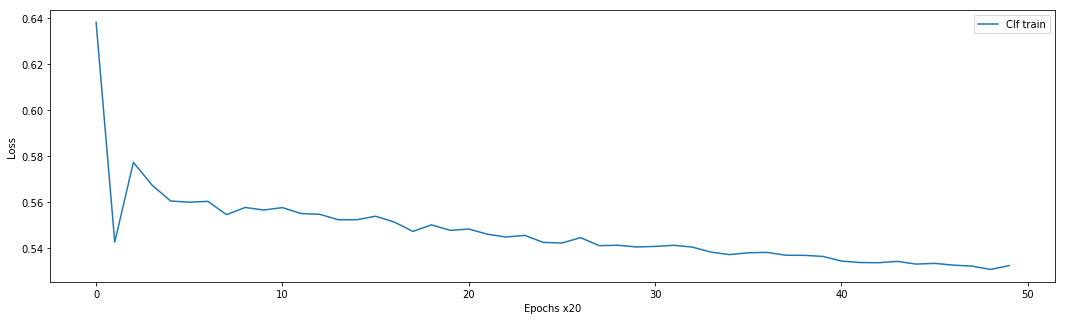

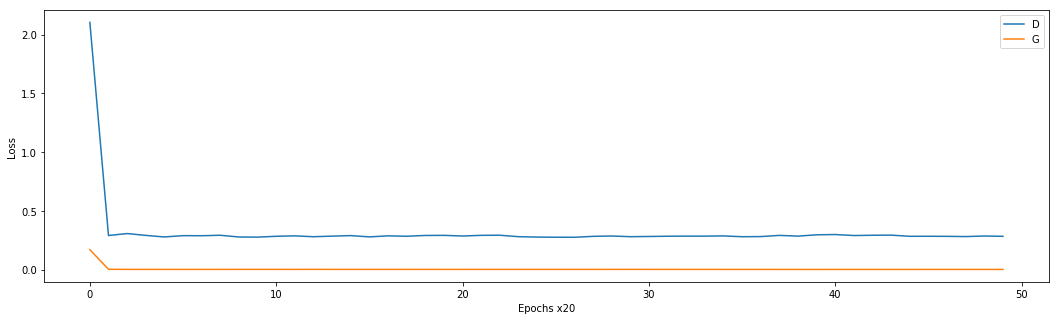

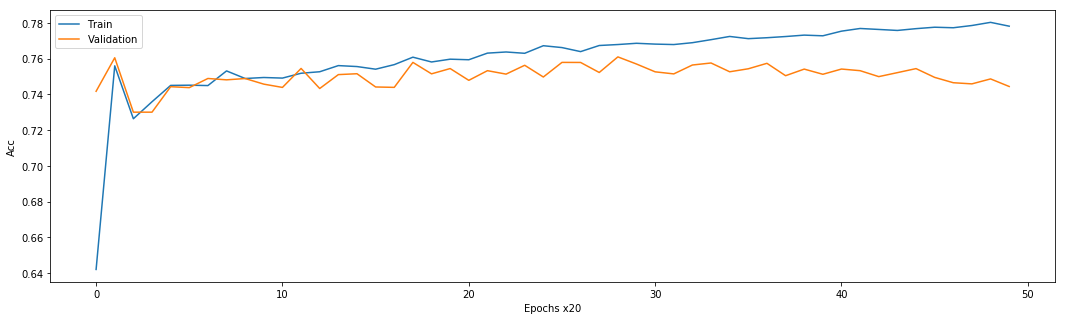

In [13]:
plt.figure(figsize=(18,5))
plt.plot(wgan_ct.stats['gp'], label='GP')

plt.plot(wgan_ct.stats['ct'], label='CT')
plt.xlabel('Epochs x20')
plt.ylabel('Loss')
plt.legend()



plt.figure(figsize=(18,5))
plt.plot(wgan_ct.stats['clf_loss'], label='Clf train')
plt.xlabel('Epochs x20')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(18,5))
plt.plot(wgan_ct.stats['d_loss'], label='D')
plt.plot(wgan_ct.stats['g_loss'], label='G')
plt.xlabel('Epochs x20')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(18,5))
plt.plot(wgan_ct.stats['clf_acc'], label='Train')
plt.plot(wgan_ct.stats['clf_acc_val'], label='Validation')
plt.xlabel('Epochs x20')
plt.ylabel('Acc')
plt.legend()

In [8]:
wgan_ct._consistency_term(X[:10].cuda())

tensor(0.5439, device='cuda:0', grad_fn=<MeanBackward0>)

In [11]:
data = X[:10].cuda()
d1, d_1 = wgan_ct.D(data)
d2, d_2 = wgan_ct.D(data)

In [12]:
print(d1.shape, d_1.shape)

torch.Size([10, 1]) torch.Size([10, 8192])


In [49]:
ct = 2.0*((d1.view(-1) - d2.view(-1))**2+0.1*((d_1.view(-1) - d_2.view(-1))**2).mean())
torch.max(ct,torch.zeros_like(ct)).mean()
ct

tensor([0.0012, 0.0061, 0.0044, 0.0043, 0.0034, 0.0013, 0.0010, 0.0051, 0.0062,
        0.0117], device='cuda:0', grad_fn=<MulBackward0>)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<MaxBackward2>)

In [31]:
((d1.view(-1) - d2.view(-1))**2).sqrt()

tensor([0.0108, 0.0506, 0.0414, 0.0410, 0.0346, 0.0129, 0.0022, 0.0457, 0.0513,
        0.0733], device='cuda:0', grad_fn=<SqrtBackward>)

In [30]:
(d1 - d2).norm(2, dim=1).mean()

tensor(0.0364, device='cuda:0', grad_fn=<MeanBackward0>)

In [19]:
gen = Generator(64,64,3).cuda()
noise = torch.FloatTensor(10, 100).normal_(0, 1).cuda()

data_fake = gen(noise)
data_fake.shape

torch.Size([10, 32768])
torch.Size([10, 128, 16, 16])


torch.Size([10, 3, 64, 64])

In [155]:
dis = Discriminator(64,64,3).cuda()
dis(tmp)[0].shape


torch.Size([10])

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

# ================== main script ======================

netG = Generator()
netG.apply(weights_init)
netD = Discriminator()
netD.apply(weights_init)

print netG
print netD

if use_cuda:
    netD = netD.cuda()
    netG = netG.cuda()

optimizerD = optim.Adam(netD.parameters(), lr=1e-4, betas=(0.5, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr=1e-4, betas=(0.5, 0.9))

one = torch.FloatTensor([1])
mone = one * -1
zero = torch.FloatTensor([0])
if use_cuda:
    one = one.cuda()
    mone = mone.cuda()
    zero = zero.cuda()

def dataset():
    while 1:
        for images,targets in train_loader:
            #print(images)
            yield images
data=dataset()
fixed_noise = Variable(torch.randn(100, NOISE_SZ).cuda(),requires_grad = False)

for iteration in xrange(ITERS):
    ############################
    # (1) Update D network
    ###########################
    netD.train()
    for p in netD.parameters():  
        p.requires_grad = True  
    for iter_d in xrange(CRITIC_ITERS):
        _data = data.next()
        real_data = torch.Tensor(_data)
        if use_cuda:
            real_data = real_data.cuda()
        real_data_v = autograd.Variable(real_data)

        netD.zero_grad()


        # train with fake
        noise = torch.randn(BATCH_SIZE, NOISE_SZ)
        if use_cuda:
            noise = noise.cuda()
        noise_v = autograd.Variable(noise, volatile=True)  
        fake = autograd.Variable(netG(noise_v).data)
        D_fake1_1,D_fake1_2 = netD(fake)
        D_fake1 = D_fake1_1.mean()
        D_fake1.backward((one))

        # train with gradient penalty
        gradient_penalty = calc_gradient_penalty(netD, real_data_v.data, fake.data)
        gradient_penalty.backward()
               
        # train with real
        D_real1_1,D_real1_2 = netD(real_data_v)
        D_real1 = D_real1_1.mean()      
        D_real1.backward((mone),retain_graph=True)
        
        # train with CT penalty
        D_real2_1,D_real2_2 = netD(real_data_v)

        ct_penalty = LAMBDA_2*((D_real1_1-D_real2_1)**2)       
        ct_penalty += LAMBDA_2*0.1*((D_real1_2-D_real2_2)**2).mean(dim=1)
        ct_penalty = torch.max(Variable(torch.zeros(ct_penalty.size()).cuda() if use_cuda else torch.zeros(ct_penalty.size())),ct_penalty-Factor_M)
        ct_penalty = ct_penalty.mean()
        #print(ct_penalty)
        ct_penalty.backward()

        D_cost = -D_real1 + D_fake1 + gradient_penalty + ct_penalty
        #print(-D_real1.data[0] , D_fake1.data[0] , gradient_penalty.data[0] ,ct_penalty.data[0])
        #D_cost.backward()
        Wasserstein_D = D_real1 - D_fake1
        optimizerD.step()

    #if not FIXED_GENERATOR:
        ############################
        # (2) Update G network
        ###########################
    netD.eval()
    for p in netD.parameters():
        p.requires_grad = False  
    netG.zero_grad()

    noise = torch.randn(BATCH_SIZE, NOISE_SZ)
    if use_cuda:
        noise = noise.cuda()
    noisev = autograd.Variable(noise,requires_grad=True) 
    fake = netG(noisev)
    G,_ = netD(fake)
    G = G.mean()
    G.backward(mone)
    G_cost = -G
    optimizerG.step()
    print((iteration,D_cost.data[0],Wasserstein_D.data[0]))
    if iteration%100==0:
        fake = netG(fixed_noise).view(-1, 1,28,28)
        vutils.save_image(fake.data,
                    'fake_samples_epoch_%03d.png' %  iteration,
                    normalize=True)

torch.save(netG.state_dict(), 'netG_mnist.pth')
torch.save(netD.state_dict(), 'netD_mnist.pth')